# Loading needed libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import numpy as np
from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import kruskal
import scikit_posthocs as sp

plt.style.use('seaborn-darkgrid')
sns.set_context('notebook')

# Reading tables

In [5]:
# Reading CSV files
label_table = pd.read_csv("../../data/label_dataset.csv", usecols=lambda column: column != 'Unnamed: 0')
print(label_table.dtypes)  

commiters_number = pd.read_csv("committer_count_by_repo.csv", usecols=lambda column: column != 'Unnamed: 0')
print(commiters_number.dtypes)

# Joining dataframes
commiters_label = pd.merge(commiters_number, label_table, on="repo_id", how="inner")
print(commiters_label.dtypes)

# Selecting specific columns
commitersSelectedVar = commiters_label[["repo_id", "committer_count", "label_name"]]

repo_id        int64
label_name    object
dtype: object
rg_name            object
repo_group_id       int64
repo_name          object
repo_id             int64
repo_git           object
forked_from        object
repo_archived       int64
committer_count     int64
dtype: object
rg_name            object
repo_group_id       int64
repo_name          object
repo_id             int64
repo_git           object
forked_from        object
repo_archived       int64
committer_count     int64
label_name         object
dtype: object


# General Visualization

## Excluding outliers

In [7]:
# Exclude outliers
def exclude_outliers(data, variable, group_var, sd_threshold=2):
    # Function to filter outliers in a group
    def filter_group(group):
        mean_val = group[variable].mean()
        sd_val = group[variable].std()
        return group[np.abs(group[variable] - mean_val) < sd_threshold * sd_val]
    
    # Apply the filter function to each group and combine the results
    return data.groupby(group_var).apply(filter_group).reset_index(drop=True)

In [8]:
commiterSelectedVar_filtered = exclude_outliers(commitersSelectedVar, "committer_count", "label_name", sd_threshold=2)

## Calculating descriptive stats showing on the plot

In [10]:
# Calculate stats to show on the plot
stats_df = commiterSelectedVar_filtered.groupby('label_name')['committer_count'].agg(
    average='mean',
    upper_quartile=lambda x: x.quantile(0.75)
).reset_index()

stats_df['label_pos'] = stats_df['upper_quartile'] + 0.5

## Generating box plot

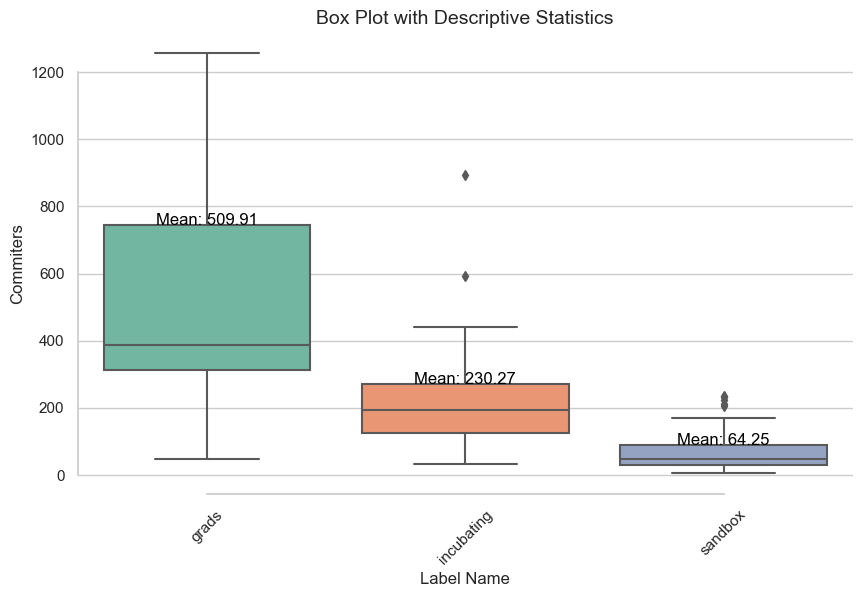

In [13]:
# Set plots style
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

# Create a boxplot
ax = sns.boxplot(x='label_name', y='committer_count', data=commiterSelectedVar_filtered, palette="Set2", dodge=True)

# Add mean values as text on the plot
for index, row in stats_df.iterrows():
    ax.text(
        x=index, 
        y=row['label_pos'], 
        s=f"Mean: {row['average']:.2f}", 
        color='black', 
        ha="center", 
        size=12
    )

# Set plot title and labels
ax.set_title('Box Plot with Descriptive Statistics', fontsize=14)
ax.set_xlabel('Label Name', fontsize=12)
ax.set_ylabel('Commiters', fontsize=12)

# Making plot easier to read
sns.despine(trim=True)
plt.xticks(rotation=45)

plt.show()

# Start testing normality and variance homogeneous
## Distribution visualization

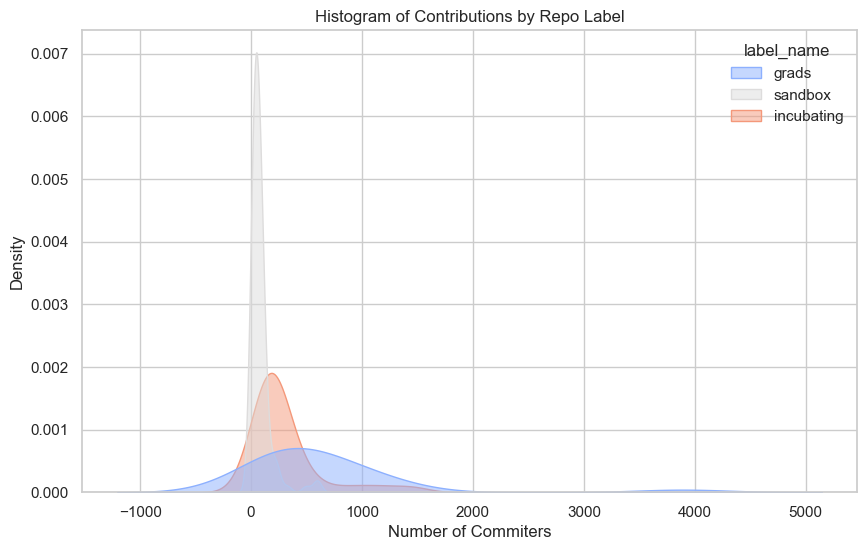

In [17]:
# Create a density plot
plt.figure(figsize=(10, 6))
sns.kdeplot(data=commitersSelectedVar, x='committer_count', hue='label_name', fill=True, common_norm=False, alpha=0.5, palette='coolwarm')
plt.title('Histogram of Contributions by Repo Label')
plt.xlabel('Number of Commiters')
plt.ylabel('Density')
plt.show()

## Kruskal-Wallis H test to test whether there is a significant difference among pairs of groups

In [21]:
# Preparing data for Kruskal-Wallis H Test
groups = [group['committer_count'].values for name, group in commitersSelectedVar.groupby('label_name')]

# Perform Kruskal-Wallis H Test
stat, p = kruskal(*groups)
print(f'Kruskal-Wallis H Test Statistic: {stat}, P-value: {p}')

Kruskal-Wallis H Test Statistic: 75.94965096491147, P-value: 3.219162068260506e-17


## Dunn's test to conduct post-hoc test for examining the differience between each pair of groups.

In [22]:
# Conduct Dunn's Test
dunn_test_result = sp.posthoc_dunn(commitersSelectedVar, val_col='committer_count', group_col='label_name', p_adjust='fdr_bh')

print(dunn_test_result)

                   grads    incubating       sandbox
grads       1.000000e+00  1.240488e-01  1.292491e-12
incubating  1.240488e-01  1.000000e+00  9.750637e-10
sandbox     1.292491e-12  9.750637e-10  1.000000e+00
